# Correlaciones lunáticas
Preparación de datos, tablas y algún gráfico. Pruebas y ensayos (y errores).

In [1]:
from os import path

path.abspath(path.curdir)
BASEDIR = path.abspath(path.curdir) + '/'
print(BASEDIR)

/media/nicamlg/TOSHIBA EXT/NICAMLG Home/Projects/DataAnalytics/TCC/


In [2]:
# --- Paso 1: Importar las librerías ---
# Estas son las herramientas que usaremos

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Configuramos un estilo bonito para los gráficos
plt.style.use('ggplot')

In [3]:
moon_phases_emoji = {
    0: '🌑',
    1: '🌒',
    2: '🌓',
    3: '🌔',
    4: '🌕',
    5: '🌖',
    6: '🌗',
    7: '🌘'
}

# Reemplazar los emojis de la Luna con texto descriptivo
moon_phases_txt = {
    0: 'Luna Nueva',
    1: 'Luna Creciente',
    2: 'Cuarto Creciente',
    3: 'Gibosa Creciente',
    4: 'Luna Llena',
    5: 'Gibosa Menguante',
    6: 'Cuarto Menguante',
    7: 'Luna Menguante',
}

weekdays = [
    'Lunes',
    'Martes',
    'Miércoles',
    'Jueves',
    'Viernes',
    'Sábado',
    'Domingo',
]

mph = pd.read_csv(BASEDIR + "data/moon_phases_2018-2024_UTC_no_lib.csv", parse_dates=["date"])
# Convierte la columa de fecha en tipo fecha (y hora)
# mph['date'] = pd.to_datetime(mph['date'])
# Añade el nombre de la fase al dataset
mph['Phase Name'] = mph['Category'].map(moon_phases_txt)
# Añade el día de la semana (¿útil? Igual no)
mph['Weekday']    = mph['date'].dt.day_name(locale='es_ES.utf8')
mph['Weekday']    = pd.Categorical(mph['Weekday'], weekdays, ordered=True)
mph['Phase Name'] = pd.Categorical(mph['Phase Name'], moon_phases_txt.values(), ordered=True)

mph

,date,Area,Category,Moon Phase,Phase,Phase Name,Weekday
0,2018-01-01,0.9205,4,🌕,4,Luna Llena,Lunes
1,2018-01-02,0.8523,4,🌕,4,Luna Llena,Martes
2,2018-01-03,0.7841,4,🌕,4,Luna Llena,Miércoles
3,2018-01-04,0.7159,5,🌖,3,Gibosa Menguante,Jueves
4,2018-01-05,0.6477,5,🌖,3,Gibosa Menguante,Viernes
...,...,...,...,...,...,...,...
2552,2024-12-27,0.0341,7,🌘,1,Luna Menguante,Viernes
2553,2024-12-28,0.0227,0,🌑,0,Luna Nueva,Sábado
2554,2024-12-29,0.0909,0,🌑,0,Luna Nueva,Domingo
2555,2024-12-30,0.1591,0,🌑,0,Luna Nueva,Lunes


## Nacimientos en Catalunya
Análisis de la influencia lunar en los nacimientos, uno de los mitos más frecuentes.

In [4]:
naix  = pd.read_csv(BASEDIR + 'data/clean_data/naixements_w_mph.csv', parse_dates=["date"])
morts = pd.read_csv(BASEDIR + 'data/clean_data/defuncions_w_mph.csv', parse_dates=["date"])

naix.rename(columns={"fase_lunar":"Fase Lunar"}, inplace=True)
morts.rename(columns={"fase_lunar":"Fase Lunar"}, inplace=True)

# Añadimos el día de la semana a los dataframes...
naix['Weekday']  =  naix['date'].dt.day_name(locale='es_ES.utf8')
morts['Weekday'] = morts['date'].dt.day_name(locale='es_ES.utf8')

# Categorizar los días de la semana y que se puedan ordenar bien
# y automáticamente ;-)
naix['Weekday']  = pd.Categorical(naix['Weekday'], weekdays, ordered=True)
morts['Weekday'] = pd.Categorical(morts['Weekday'], weekdays, ordered=True)

# Y repetimos con las fases lunares:
naix['Fase Lunar']  = pd.Categorical(naix['Fase Lunar'],  moon_phases_txt.values(), ordered=True)
morts['Fase Lunar'] = pd.Categorical(morts['Fase Lunar'], moon_phases_txt.values(), ordered=True)

In [5]:
naix

,date,homes,dones,total,num_phase,fase,Fase Lunar,Weekday
0,2019-01-01,109,94,203,7,🌘,Luna Menguante,Martes
1,2019-01-02,109,141,250,7,🌘,Luna Menguante,Miércoles
2,2019-01-03,97,107,204,0,🌑,Luna Nueva,Jueves
3,2019-01-04,89,112,201,0,🌑,Luna Nueva,Viernes
4,2019-01-05,125,106,231,0,🌑,Luna Nueva,Sábado
...,...,...,...,...,...,...,...,...
1821,2023-12-27,116,123,239,4,🌕,Luna Llena,Miércoles
1822,2023-12-28,137,122,259,4,🌕,Luna Llena,Jueves
1823,2023-12-29,117,156,273,5,🌖,Gibosa Menguante,Viernes
1824,2023-12-30,141,129,270,5,🌖,Gibosa Menguante,Sábado


### Análisis de regresión
Esto permite tenr una idea de si la correlación es solo una correlación, o es algo estadísticamente significativo.

In [6]:
# Calcular la media (mu) de accidentes para cada día
naixFasesSum = naix.groupby(["Fase Lunar"], observed=False) \
        [['dones', 'homes', 'total']] \
        .sum() \
        .reindex(moon_phases_txt.values())
naixWeekdaySum = naix.groupby(["Weekday"], observed=False) \
        [['dones', 'homes', 'total']] \
        .sum()

naixFasesSum

,dones,homes,total
Fase Lunar,,,
Luna Nueva,23617,23854,47471
Luna Creciente,20653,20724,41377
Cuarto Creciente,24192,24768,48960
Gibosa Creciente,20863,21041,41904
Luna Llena,20772,21284,42056
Gibosa Menguante,24035,24243,48278
Cuarto Menguante,20202,20213,40415
Luna Menguante,20547,21033,41580


In [7]:
naixWeekdaySum

,dones,homes,total
Weekday,,,
Lunes,23954,24528,48482
Martes,25134,25729,50863
Miércoles,25882,25736,51618
Jueves,25497,25862,51359
Viernes,25885,26379,52264
Sábado,25036,25313,50349
Domingo,23493,23613,47106


<AxesSubplot: title={'center': 'Nacimientos por Fase de la Luna'}, xlabel='Fase Lunar'>

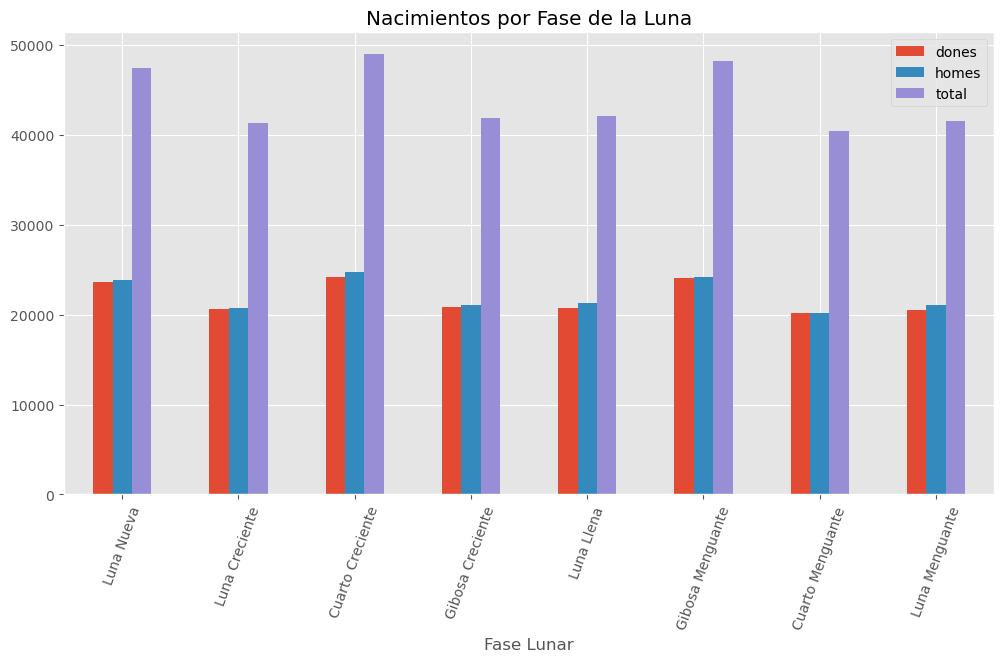

In [43]:
naixFasesSum.reindex(moon_phases_txt.values()) \
        .plot.bar(
            rot=70,
            figsize=(12,6),
            title="Nacimientos por Fase de la Luna",
        )

<AxesSubplot: title={'center': 'Nacimientos por día de la semana'}, xlabel='Día de la semana'>

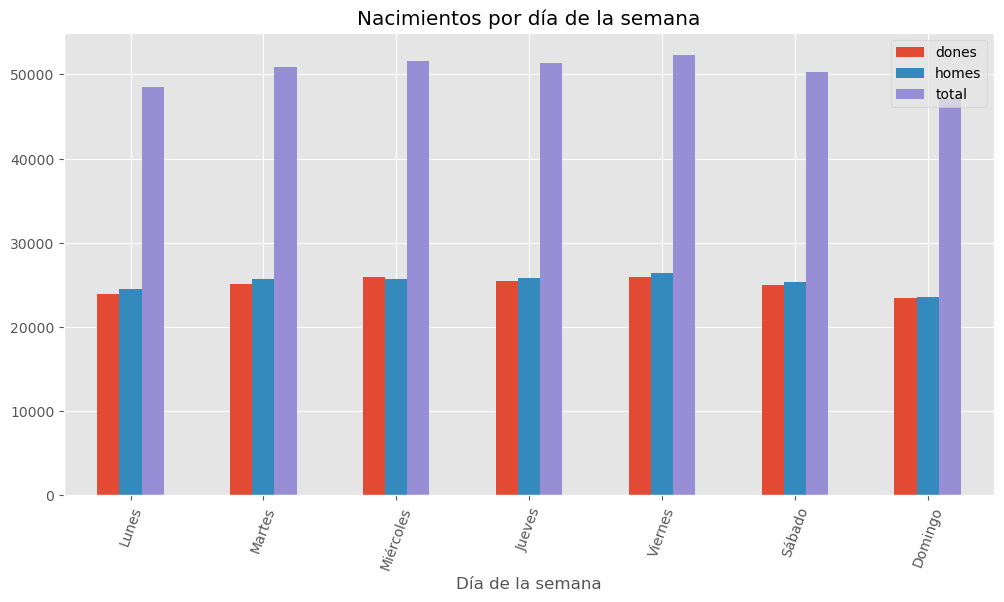

In [45]:
naixWeekdaySum.plot \
        .bar(
            rot=70,
            figsize=(12,6),
            title="Nacimientos por día de la semana",
            xlabel="Día de la semana"
        )

In [12]:
# Creamos funciones, ya que lo haremos para cada dataset
def calc_dispersion(df,  title: str="Dispersión", column: str="total"):
    # Preanálisis
    print("\n--- Comprobación Numérica (Media vs. Varianza) ---")

    agregados = df.groupby('Weekday', observed=False)[column] \
                    .agg(['min', 'mean', 'max', 'var'])
    #agregados.sort_index()
    print(agregados)
    plot_overdispersion(agregados, title)

def calc_dispersion_lph(df,  title: str="Dispersión", column: str="total"):
    # Preanálisis
    print("\n--- Comprobación Numérica (Media vs. Varianza) ---")

    agregados = df.groupby('Fase Lunar', observed=False)[column] \
                    .agg(['min', 'mean', 'max', 'var'])
    #agregados.sort_index()
    print(agregados)
    plot_overdispersion(agregados, title)

def plot_overdispersion(agregados, title: str=''):
    last_word = title.split(' ')[-1]
    plt.figure(figsize=(8, 6))
    plt.scatter(agregados['mean'], agregados['var'], color='blue', s=100, zorder=5, label='Datos (Agrupados por Día)')
    max_val = max(agregados['mean'].max(), agregados['var'].max())
    plt.plot([0, max_val], [0, max_val], 'r--', label='Línea de Poisson (Varianza = Media)')
    plt.title(title or 'Demostración Visual de Sobredispersión', fontsize=16)
    plt.xlabel(f'Media de {last_word} (μ)', fontsize=12)
    plt.ylabel(f'Varianza de {last_word} (σ²)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.axis('equal')
    plt.show()

def binomial_anaysis(df, columna, title="Análisis binomial"):
    # Preanálisis
    print("\n--- Comprobación Numérica (Media vs. Varianza) ---")

    agregados = df.groupby('Weekday', observed=False)[columna] \
                    .agg(['min', 'mean', 'max', 'var'])
    #agregados.sort_index()
    print(agregados)
    plot_overdispersion(agregados, title)

    formula = f'{columna} ~ C(Q("Fase Lunar")) + C(Weekday)'
    model   = smf.glm(
        formula=formula,
        data=df,
        family=sm.families.NegativeBinomial(alpha=1.0)
    )
    results = model.fit() # ajustando el modelo a los datos
    return results


--- Comprobación Numérica (Media vs. Varianza) ---
           min        mean  max          var
Weekday                                     
Lunes      125  186.469231  653  2767.022216
Martes     125  194.877395  646  2794.800295
Miércoles  127  197.770115  595  2525.085411
Jueves     138  196.777778  580  2441.727350
Viernes    134  200.245211  593  2661.939640
Sábado     113  192.908046  604  2539.606897
Domingo    120  180.482759  608  2599.681432


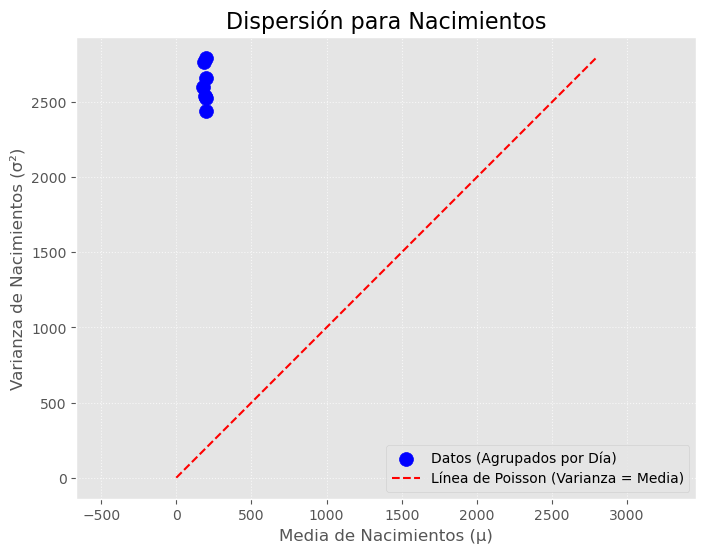

In [13]:
# Preanálisis
calc_dispersion(naix, 'Dispersión para Nacimientos')


--- Comprobación Numérica (Media vs. Varianza) ---
                  min        mean  max          var
Fase Lunar                                         
Luna Nueva        127  191.415323  510  2206.826809
Luna Creciente    122  191.560185  604  2941.614966
Cuarto Creciente  113  195.059761  653  3928.168414
Gibosa Creciente  125  194.000000  593  3505.572093
Luna Llena        125  192.917431  563  2702.665962
Gibosa Menguante  135  194.669355  545  2470.748531
Cuarto Menguante  120  189.741784  434  1806.041501
Luna Menguante    129  192.500000  416  1586.046512


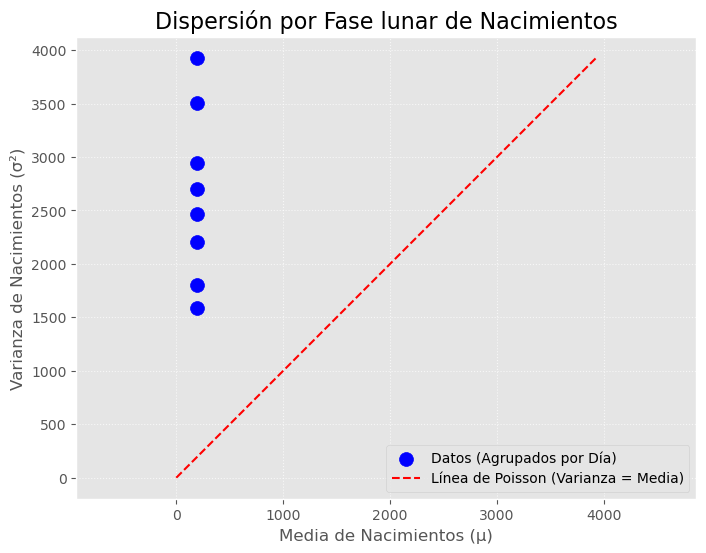

In [14]:
calc_dispersion_lph(naix, 'Dispersión por Fase lunar de Nacimientos', 'total')


--- Comprobación Numérica (Media vs. Varianza) ---
                  min       mean  max          var
Fase Lunar                                        
Luna Nueva         53  96.185484  270   661.495821
Luna Creciente     57  95.944444  307   817.941085
Cuarto Creciente   51  98.677291  341  1112.443442
Gibosa Creciente   58  97.412037  300   898.438738
Luna Llena         63  97.633028  275   666.196508
Gibosa Menguante   59  97.754032  268   512.923061
Cuarto Menguante   58  94.896714  204   450.828904
Luna Menguante     63  97.375000  197   387.835465


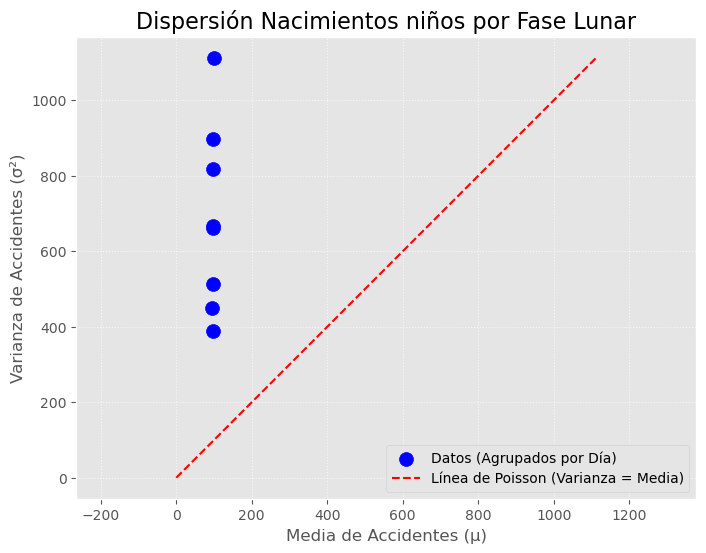

In [62]:
calc_dispersion_lph(naix, 'Dispersión Nacimientos niños por Fase Lunar', 'homes')


--- Comprobación Numérica (Media vs. Varianza) ---
                  min       mean  max         var
Fase Lunar                                       
Luna Nueva         54  95.229839  240  561.870037
Luna Creciente     58  95.615741  307  756.479565
Cuarto Creciente   60  96.382470  314  977.053131
Gibosa Creciente   56  96.587963  293  951.573622
Luna Llena         51  95.284404  294  796.978650
Gibosa Menguante   63  96.915323  293  849.454339
Cuarto Menguante   59  94.845070  240  563.225884
Luna Menguante     56  95.125000  221  541.858721


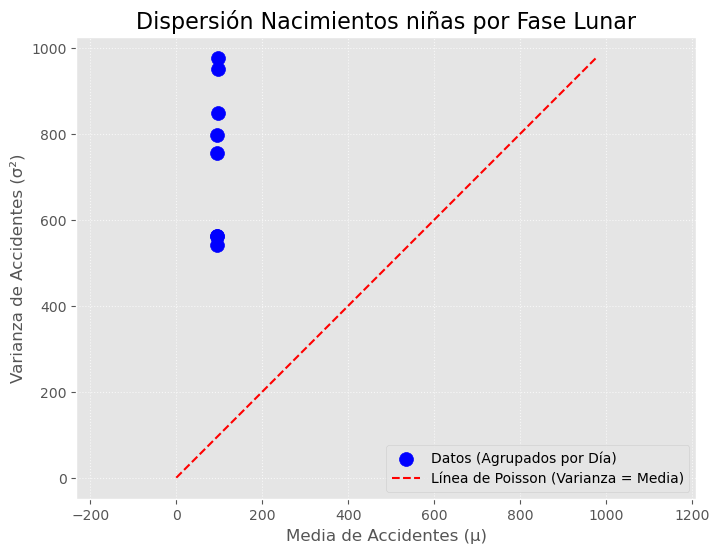

In [63]:
calc_dispersion_lph(naix, 'Dispersión Nacimientos niñas por Fase Lunar', 'dones')

## Análisis de regresión binomial
Con este análisis veremos si el día de la semana, o el ciclo lunar, o ninguno de los dos parámetros, tiene influencia significativa ( < 0.05, o un 5%) sobre los datos a analizar. Empezaremos con las cifras de nacimientos.

In [50]:
analisis = binomial_anaysis(naix, 'total')
# print(analisis.summary())

analisis.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Generalized linear model
=====================================================================================
Model:                     GLM                     AIC:                   22902.6737 
Link Function:             Log                     BIC:                   -13523.6894
Dependent Variable:        total                   Log-Likelihood:        -11437.    
Date:                      2025-10-27 00:39        LL-Null:               -11438.    
No. Observations:          1826                    Deviance:              84.219     
Df Model:                  13                      Pearson chi2:          127.       
Df Residuals:              1812                    Scale:                 1.0000     
Method:                    IRLS                                                      
-------------------------------------------------------------------------------------
                                        Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                               5.2228   0.0855 61.0505 0.0000  5.0551 5.3905
C(Q("Fase Lunar"))[T.Luna Creciente]   -0.0029   0.0933 -0.0306 0.9756 -0.1858 0.1801
C(Q("Fase Lunar"))[T.Cuarto Creciente]  0.0183   0.0898  0.2041 0.8383 -0.1576 0.1943
C(Q("Fase Lunar"))[T.Gibosa Creciente]  0.0111   0.0933  0.1186 0.9056 -0.1718 0.1940
C(Q("Fase Lunar"))[T.Luna Llena]        0.0076   0.0931  0.0821 0.9346 -0.1748 0.1901
C(Q("Fase Lunar"))[T.Gibosa Menguante]  0.0145   0.0901  0.1610 0.8721 -0.1620 0.1910
C(Q("Fase Lunar"))[T.Cuarto Menguante] -0.0091   0.0937 -0.0976 0.9222 -0.1927 0.1744
C(Q("Fase Lunar"))[T.Luna Menguante]    0.0024   0.0933  0.0256 0.9795 -0.1805 0.1853
C(Weekday)[T.Martes]                    0.0439   0.0879  0.4998 0.6172 -0.1283 0.2161
C(Weekday)[T.Miércoles]                 0.0587   0.0879  0.6676 0.5044 -0.1136 0.2309
C(Weekday)[T.Jueves]                    0.0535   0.0879  0.6084 0.5429 -0.1188 0.2257
C(Weekday)[T.Viernes]                   0.0712   0.0879  0.8101 0.4179 -0.1010 0.2434
C(Weekday)[T.Sábado]                    0.0338   0.0879  0.3846 0.7005 -0.1384 0.2060
C(Weekday)[T.Domingo]                  -0.0329   0.0879 -0.3747 0.7079 -0.2051 0.1393
=====================================================================================

"""

El valor de referencia (Intercept) está en los Lunes con Luna Nueva (el que no aparece en la lista). Ese sería, entonces, el "día más normal".

Analizando el valor `P>|z|` (llamado "p.value"), asumiendo un porcentaje mínimo del 5% (0.05), y teniendo en cuenta que **todos** los valores (menos el viernes, que es de un 41,8%) está sobre el 50%, es decir, 10 veces superior al umbral, la regresión binomial nos dice que no hay influencia ni en los díasd de la semana (es decir, que "más o menos" hay los mismos partos todos los días, excepto los viernes¹).

Este último dato tiene que ver, muy probablemente, con el hecho de que muchos partos serán inducidos, o serán cesáreas, programadas en viernes, para poder tener un fin de semana de recuperación tranquila (dentro de lo posible para ese tipo de trauma). Pero, en todo caso, la Luna nada tiene que ver.

Observamos que los valores P<|z| de los días de la semana rondan el 50%, mientras que todos los valores para las fases lunares superan el **`75%`**.

A modo de curiosidad, veamos las cifras para niños y niñas, ya que las tenemos:


In [51]:
print(
    "Análisis binomial de nacimientos de varones:\n",
    binomial_anaysis(naix, 'homes').summary(),
    "\n\nAnálisis binomial de nacimientos de féminas:\n",
    binomial_anaysis(naix, 'dones').summary(),
)


Análisis binomial de nacimientos de varones:
                  Generalized Linear Model Regression Results                  
Dep. Variable:                  homes   No. Observations:                 1826
Model:                            GLM   Df Residuals:                     1812
Model Family:        NegativeBinomial   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10188.
Date:                Mon, 27 Oct 2025   Deviance:                       89.644
Time:                        00:41:06   Pearson chi2:                     130.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.001297
Covariance Type:            nonrobust                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------


Como era de esperar, los datos derefefencia son igualmente el lunes en Luna Nueva en ambos casos, con resultados similares. De hecho, el resultado de P>|z| de las niñas está **siempre** por encima del 89%. Las niñas están negando cualquier participación lunática en sus naciimientos.


### Análisis de los registros de defunciones
Veamos ahora las cifras para las defunciones en Catalunya, empezando por el análisis de dispersión general (niños y niñas).


--- Comprobación Numérica (Media vs. Varianza) ---
           min        mean  max          var
Weekday                                     
Lunes      125  186.469231  653  2767.022216
Martes     125  194.877395  646  2794.800295
Miércoles  127  197.770115  595  2525.085411
Jueves     138  196.777778  580  2441.727350
Viernes    134  200.245211  593  2661.939640
Sábado     113  192.908046  604  2539.606897
Domingo    120  180.482759  608  2599.681432


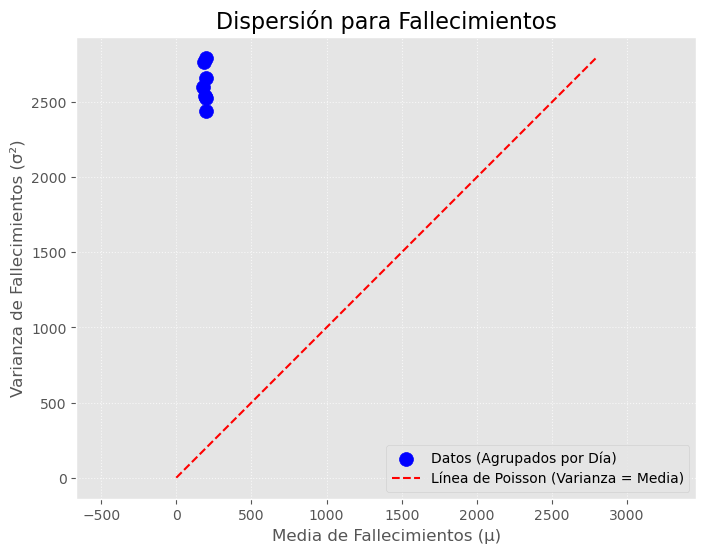

In [15]:
# Preanálisis
calc_dispersion(morts, 'Dispersión para Fallecimientos')

De nuevo, se va por los Cerros de Úbeda... Vayamos entonces con el análisis polinomial, empezando por los valores totales.

In [14]:
analisis_total = binomial_anaysis(morts, 'total')
analisis_homes = binomial_anaysis(morts, 'homes')
analisis_dones = binomial_anaysis(morts, 'dones')

analisis_total.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Generalized linear model
=====================================================================================
Model:                     GLM                     AIC:                   22902.6737 
Link Function:             Log                     BIC:                   -13523.6894
Dependent Variable:        total                   Log-Likelihood:        -11437.    
Date:                      2025-10-26 17:09        LL-Null:               -11438.    
No. Observations:          1826                    Deviance:              84.219     
Df Model:                  13                      Pearson chi2:          127.       
Df Residuals:              1812                    Scale:                 1.0000     
Method:                    IRLS                                                      
-------------------------------------------------------------------------------------
                                        Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                               5.2228   0.0855 61.0505 0.0000  5.0551 5.3905
C(Q("Fase Lunar"))[T.Luna Creciente]   -0.0029   0.0933 -0.0306 0.9756 -0.1858 0.1801
C(Q("Fase Lunar"))[T.Cuarto Creciente]  0.0183   0.0898  0.2041 0.8383 -0.1576 0.1943
C(Q("Fase Lunar"))[T.Gibosa Creciente]  0.0111   0.0933  0.1186 0.9056 -0.1718 0.1940
C(Q("Fase Lunar"))[T.Luna Llena]        0.0076   0.0931  0.0821 0.9346 -0.1748 0.1901
C(Q("Fase Lunar"))[T.Gibosa Menguante]  0.0145   0.0901  0.1610 0.8721 -0.1620 0.1910
C(Q("Fase Lunar"))[T.Cuarto Menguante] -0.0091   0.0937 -0.0976 0.9222 -0.1927 0.1744
C(Q("Fase Lunar"))[T.Luna Menguante]    0.0024   0.0933  0.0256 0.9795 -0.1805 0.1853
C(Weekday)[T.Martes]                    0.0439   0.0879  0.4998 0.6172 -0.1283 0.2161
C(Weekday)[T.Miércoles]                 0.0587   0.0879  0.6676 0.5044 -0.1136 0.2309
C(Weekday)[T.Jueves]                    0.0535   0.0879  0.6084 0.5429 -0.1188 0.2257
C(Weekday)[T.Viernes]                   0.0712   0.0879  0.8101 0.4179 -0.1010 0.2434
C(Weekday)[T.Sábado]                    0.0338   0.0879  0.3846 0.7005 -0.1384 0.2060
C(Weekday)[T.Domingo]                  -0.0329   0.0879 -0.3747 0.7079 -0.2051 0.1393
=====================================================================================

"""

Como medio sorpresa, el valor de referencia vuelve a ser los lunes con la Luna Nueva. ¿Será esto significativo? Pues no: al reordenar las fases lunares y poner, por ejemplo, el Cuarto Creciente el primero, eligió esa fase lunar como referencia, lo que hace pensar que, a falta de valores de referencia mejores, ha elegido el primero de cada categoría ("Luna Nueva" y "Lunes").

Pero no se queda aquí... Observamos, otra vez, cómo los viernes tenemos el valor de P>|z| más bajo, un 41,79%. Aquí no hay cesáreas que valgan.

Podríamos volvernos lunáticos y empezar a ver conspiraciones del Universo... Pero debemos entender que no es estadísticamente relevante hasta que no bajamos del 5%. Así que mejor atenernos a las Matemáticas (que es ele lenguaje del Universo, después de todo).

Solo por completismo, y que que está calculado, veamos los datos por género:


--- Comprobación Numérica (Media vs. Varianza) ---
                  min        mean  max          var
Fase Lunar                                         
Luna Nueva        127  191.415323  510  2206.826809
Luna Creciente    122  191.560185  604  2941.614966
Cuarto Creciente  113  195.059761  653  3928.168414
Gibosa Creciente  125  194.000000  593  3505.572093
Luna Llena        125  192.917431  563  2702.665962
Gibosa Menguante  135  194.669355  545  2470.748531
Cuarto Menguante  120  189.741784  434  1806.041501
Luna Menguante    129  192.500000  416  1586.046512


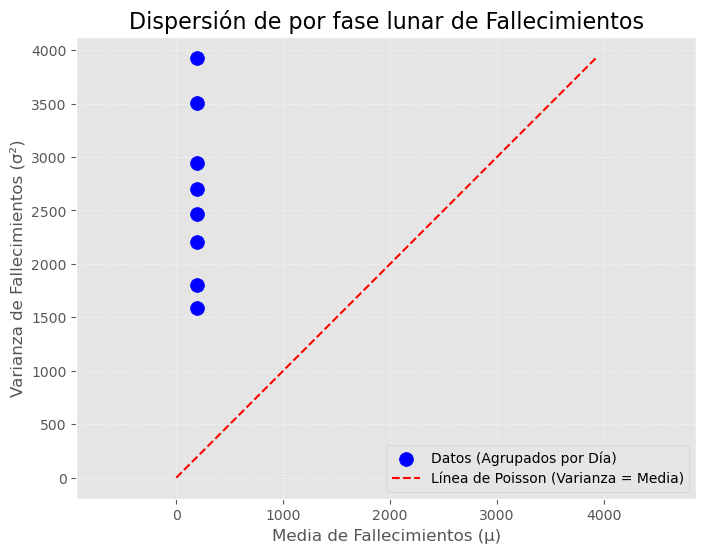

In [16]:
calc_dispersion_lph(morts, "Dispersión de por fase lunar de Fallecimientos")

In [15]:
analisis_homes.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Generalized linear model
=====================================================================================
Model:                     GLM                     AIC:                   20404.0138 
Link Function:             Log                     BIC:                   -13518.2644
Dependent Variable:        homes                   Log-Likelihood:        -10188.    
Date:                      2025-10-26 17:10        LL-Null:               -10189.    
No. Observations:          1826                    Deviance:              89.644     
Df Model:                  13                      Pearson chi2:          130.       
Df Residuals:              1812                    Scale:                 1.0000     
Method:                    IRLS                                                      
-------------------------------------------------------------------------------------
                                        Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                               4.5402   0.0858 52.9348 0.0000  4.3721 4.7084
C(Q("Fase Lunar"))[T.Luna Creciente]   -0.0064   0.0936 -0.0684 0.9455 -0.1898 0.1770
C(Q("Fase Lunar"))[T.Cuarto Creciente]  0.0249   0.0900  0.2762 0.7824 -0.1515 0.2012
C(Q("Fase Lunar"))[T.Gibosa Creciente]  0.0102   0.0936  0.1095 0.9128 -0.1731 0.1936
C(Q("Fase Lunar"))[T.Luna Llena]        0.0144   0.0933  0.1546 0.8771 -0.1685 0.1973
C(Q("Fase Lunar"))[T.Gibosa Menguante]  0.0133   0.0903  0.1476 0.8827 -0.1636 0.1903
C(Q("Fase Lunar"))[T.Cuarto Menguante] -0.0144   0.0939 -0.1528 0.8785 -0.1984 0.1697
C(Q("Fase Lunar"))[T.Luna Menguante]    0.0087   0.0936  0.0929 0.9260 -0.1747 0.1921
C(Weekday)[T.Martes]                    0.0436   0.0881  0.4954 0.6203 -0.1290 0.2163
C(Weekday)[T.Miércoles]                 0.0440   0.0881  0.4993 0.6176 -0.1287 0.2166
C(Weekday)[T.Jueves]                    0.0489   0.0881  0.5553 0.5787 -0.1237 0.2216
C(Weekday)[T.Viernes]                   0.0689   0.0881  0.7821 0.4341 -0.1037 0.2415
C(Weekday)[T.Sábado]                    0.0275   0.0881  0.3127 0.7545 -0.1451 0.2002
C(Weekday)[T.Domingo]                  -0.0422   0.0881 -0.4794 0.6316 -0.2149 0.1304
=====================================================================================

"""

In [16]:
analisis_dones.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Generalized linear model
=====================================================================================
Model:                     GLM                     AIC:                   20357.1454 
Link Function:             Log                     BIC:                   -13508.0825
Dependent Variable:        dones                   Log-Likelihood:        -10165.    
Date:                      2025-10-23 12:18        LL-Null:               -10166.    
No. Observations:          1826                    Deviance:              99.826     
Df Model:                  13                      Pearson chi2:          146.       
Df Residuals:              1812                    Scale:                 1.0000     
Method:                    IRLS                                                      
-------------------------------------------------------------------------------------
                                        Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                               4.5190   0.0858 52.6818 0.0000  4.3508 4.6871
C(Q("Fase Lunar"))[T.Luna Creciente]    0.0008   0.0936  0.0084 0.9933 -0.1826 0.1842
C(Q("Fase Lunar"))[T.Cuarto Creciente]  0.0118   0.0900  0.1306 0.8961 -0.1646 0.1882
C(Q("Fase Lunar"))[T.Gibosa Creciente]  0.0119   0.0936  0.1270 0.8989 -0.1715 0.1953
C(Q("Fase Lunar"))[T.Luna Llena]        0.0007   0.0933  0.0076 0.9940 -0.1822 0.1836
C(Q("Fase Lunar"))[T.Gibosa Menguante]  0.0156   0.0903  0.1732 0.8625 -0.1613 0.1926
C(Q("Fase Lunar"))[T.Cuarto Menguante] -0.0039   0.0939 -0.0415 0.9669 -0.1880 0.1802
C(Q("Fase Lunar"))[T.Luna Menguante]   -0.0040   0.0936 -0.0432 0.9655 -0.1875 0.1794
C(Weekday)[T.Martes]                    0.0442   0.0881  0.5018 0.6158 -0.1285 0.2169
C(Weekday)[T.Miércoles]                 0.0735   0.0881  0.8340 0.4043 -0.0992 0.2461
C(Weekday)[T.Jueves]                    0.0581   0.0881  0.6594 0.5097 -0.1146 0.2308
C(Weekday)[T.Viernes]                   0.0735   0.0881  0.8347 0.4039 -0.0991 0.2462
C(Weekday)[T.Sábado]                    0.0402   0.0881  0.4561 0.6483 -0.1325 0.2128
C(Weekday)[T.Domingo]                  -0.0235   0.0881 -0.2664 0.7900 -0.1961 0.1492
=====================================================================================

"""

Por extraño que parezca, vemos el mismo patrón: en las mujeres los valores de P>|z| están **siempre** por encima del 85% (del 86%, de hecho, el más bajo, y 89% el resto) y 4 de ellos por encima del 90%. Es casi como si las mujeeres estuviesen negando vehementemente esa  posible influencia... :-D

[De nuevo: las Matemáticas nos dicen que pasado el umbral del 10%, **nada** es estadísticamente significativo...]

Veamos un gráfico para ver si esos valores estadísticos corresponden con los datos absolutos:

In [30]:
mortsPhaseSum = morts.groupby('Fase Lunar', observed=False)[['homes', 'dones', 'total']].sum()
mortsPhaseSum

,homes,dones,total
Fase Lunar,,,
Luna Nueva,23854,23617,47471
Luna Creciente,20724,20653,41377
Cuarto Creciente,24768,24192,48960
Gibosa Creciente,21041,20863,41904
Luna Llena,21284,20772,42056
Gibosa Menguante,24243,24035,48278
Cuarto Menguante,20213,20202,40415
Luna Menguante,21033,20547,41580


In [31]:
mortsWeekdaySum = morts.groupby('Weekday', observed=False)[['homes', 'dones', 'total']].sum()
mortsWeekdaySum

,homes,dones,total
Weekday,,,
Lunes,24528,23954,48482
Martes,25729,25134,50863
Miércoles,25736,25882,51618
Jueves,25862,25497,51359
Viernes,26379,25885,52264
Sábado,25313,25036,50349
Domingo,23613,23493,47106


<AxesSubplot: title={'center': 'Defunciones por fase lunar'}, xlabel='Fase Lunar'>

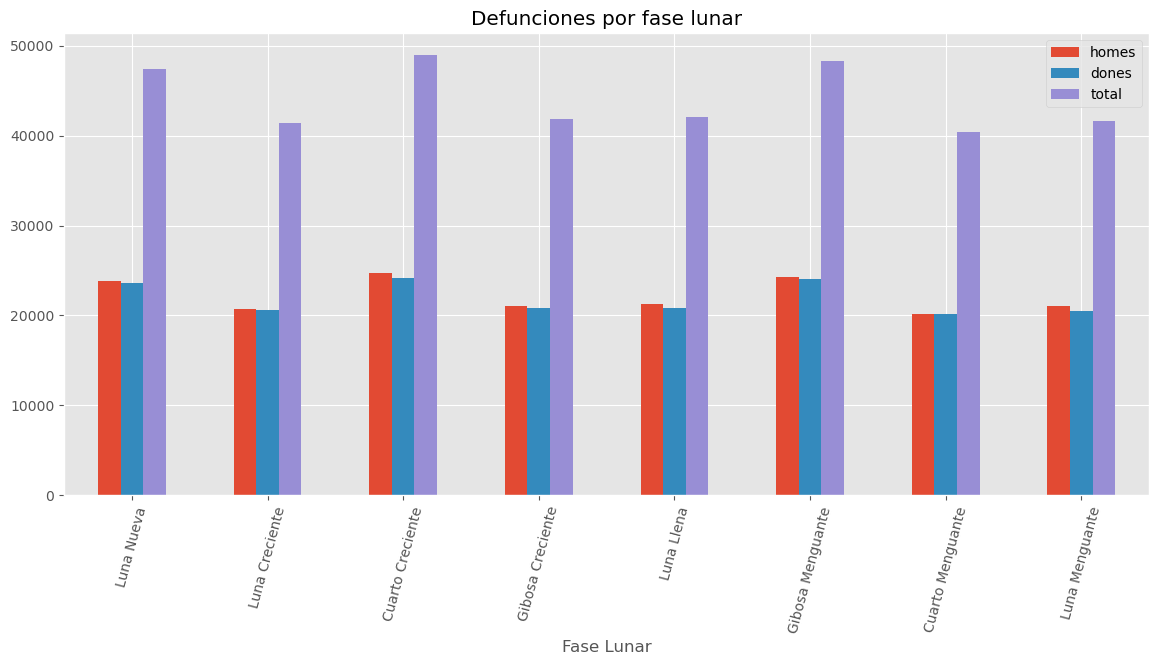

In [28]:
mortsPhaseSum.plot.bar(
            rot=75,
            title="Defunciones por fase lunar",
            figsize=(14,6),
        )

<AxesSubplot: title={'center': 'Defunciones por día de la semana'}, xlabel='Weekday'>

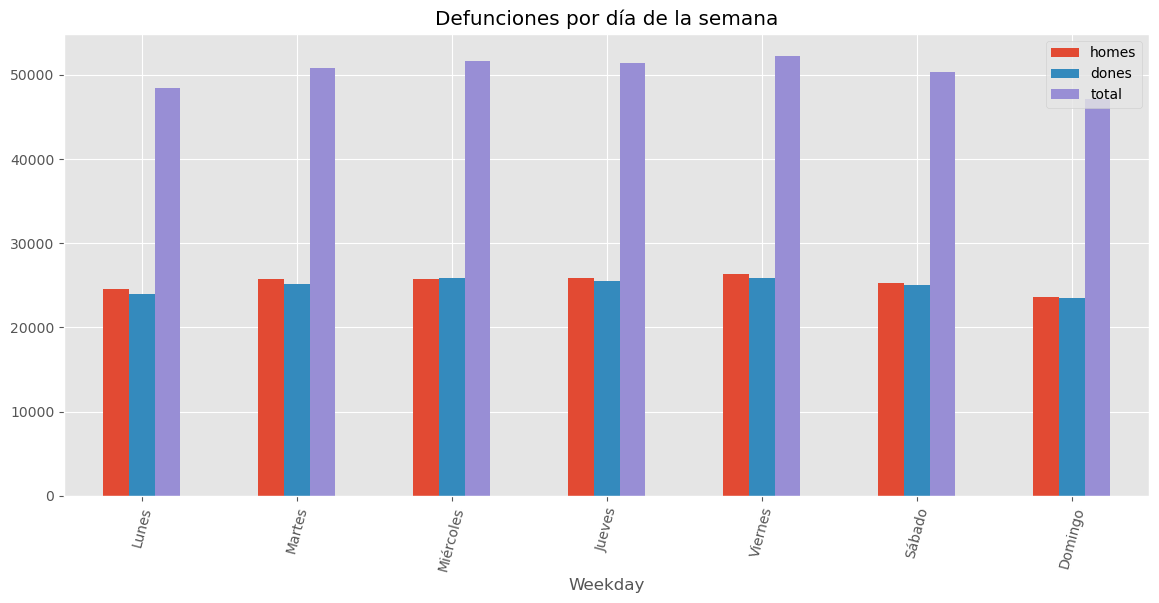

In [29]:
mortsWeekdaySum.plot.bar(
            rot=75,
            title="Defunciones por día de la semana",
            figsize=(14,6),
        )

## Accidentes de tráfico
Otro de los eventos humanos que hemos calificado como susceptibles de tener cierta influencia astral son los accidentes de tráfico.

No tiene más sentido que el hecho de que antes de la invención de las farolas con luz de gas y, posteriormente con el uso de la electricidad y la consecuente facilidad para extender la red e iluminar muchímos más caminos, calles y especialmente carreteras, la Luna Llena era "la farola" y, claro, es más probable tener un accidente sin luz (Luna Nueva o lunas creciente o menguante) que con luz (Luna Llena o Gibosas).

Puesto que no disponemos de datos del s. XIX, tendremos que atenernos a datos recientes, así que haremos un análisis rápido de accidentes de tráfico en Barcelona (accidentes urbanos) del último lustro: de 2018 a 2024.

In [21]:
accidents = pd.read_csv(
    BASEDIR + 'data/OpenDataBCN_GU/bcn_accidentes.csv',
    parse_dates=["Data"]
)

# Agregamos las columns de día de la semana y las de fase lunar y nombre de la fase
accidents['Weekday'] = accidents['Data'].dt.day_name(locale='es_ES.utf8')
accidents['Weekday']  = pd.Categorical(accidents['Weekday'], weekdays)
accidents = accidents.merge(
    mph[['date', 'Moon Phase', 'Phase Name']],
    left_on=["Data"],
    right_on=["date"],
    how="inner"
).drop("date", axis=1)
accidents.rename(
    columns={
        "Moon Phase":"Fase",
        "Phase Name":"Fase Lunar",
    },
    inplace=True)
print(accidents.head())
accidents['Fase Lunar']  = pd.Categorical(
    accidents['Fase Lunar'],
    categories=moon_phases_txt.values(),
    ordered=True
)
accidents['Descripcio_torn'] = pd.Categorical(
    accidents['Descripcio_torn'],
    categories=["Matí", "Tarda", "Nit"],
    ordered=True
)
accidents['Weekday']  = pd.Categorical(accidents['Weekday'], weekdays, ordered=True)
accidents

        Data Descripcio_torn  Numero_victimes  Longitud    Latitud Weekday  \
0 2018-01-01            Matí              0.0  2.180756  41.428673   Lunes   
1 2018-01-01            Matí              1.0  2.179432  41.463661   Lunes   
2 2018-01-01             Nit              0.0  2.187038  41.382218   Lunes   
3 2018-01-01             Nit              1.0  2.148281  41.386492   Lunes   
4 2018-01-01             Nit              1.0  2.175728  41.394232   Lunes   

  Fase  Fase Lunar  
0    🌕  Luna Llena  
1    🌕  Luna Llena  
2    🌕  Luna Llena  
3    🌕  Luna Llena  
4    🌕  Luna Llena  


,Data,Descripcio_torn,Numero_victimes,Longitud,Latitud,Weekday,Fase,Fase Lunar
0,2018-01-01,Matí,0.0,2.180756,41.428673,Lunes,🌕,Luna Llena
1,2018-01-01,Matí,1.0,2.179432,41.463661,Lunes,🌕,Luna Llena
2,2018-01-01,Nit,0.0,2.187038,41.382218,Lunes,🌕,Luna Llena
3,2018-01-01,Nit,1.0,2.148281,41.386492,Lunes,🌕,Luna Llena
4,2018-01-01,Nit,1.0,2.175728,41.394232,Lunes,🌕,Luna Llena
...,...,...,...,...,...,...,...,...
57144,2024-12-31,Tarda,1.0,2.175002,41.415940,Martes,🌑,Luna Nueva
57145,2024-12-31,Tarda,1.0,2.177080,41.424187,Martes,🌑,Luna Nueva
57146,2024-12-31,Tarda,1.0,2.207668,41.440686,Martes,🌑,Luna Nueva
57147,2024-12-31,Tarda,1.0,2.207931,41.440744,Martes,🌑,Luna Nueva


Veamos entonces, para empezar, si tenemos más accidentes por las mañanas, tardes, noches o qué día de la semana...

In [22]:
acc = accidents

acc.groupby('Descripcio_torn', observed=False)[["Numero_victimes"]].agg(["sum", "count"])

Numero_victimes       
                            sum  count
Descripcio_torn                       
Matí                    24945.0  21686
Tarda                   33973.0  28149
Nit                      7351.0   6498

Parece que por las mañanas se producen más accidentes... Parece ir en contra de la lógica de "a menos luz, más accidentes", pero también es cierto que el tráfico por las mañanas es mucho mayor e intenso... Hay muchos factores que habría que tener en cuenta, como la densidad, meteorología, obras, desvíos y más (y que no tenemos, claro). Veamos qué ocurre los días de la semana:

In [23]:
acc_x_weekday = acc.groupby("Weekday", observed=False)["Numero_victimes"].agg(["sum", "count"])
print(acc_x_weekday.to_csv())
acc_x_weekday

Weekday,sum,count
Lunes,9803.0,8429
Martes,10264.0,8810
Miércoles,10571.0,9067
Jueves,10699.0,9216
Viernes,10981.0,9457
Sábado,7955.0,6434
Domingo,5996.0,4920



,sum,count
Weekday,,
Lunes,9803.0,8429
Martes,10264.0,8810
Miércoles,10571.0,9067
Jueves,10699.0,9216
Viernes,10981.0,9457
Sábado,7955.0,6434
Domingo,5996.0,4920


Vaya, quién iba a decir que se producen más accidentes entre semana que en fin de semana... Pero en realidad, volvemos a los mismo: hay más coches en días laborables que en fin de semana. Volveremos a este punto más adelante, cuando hagamos un simple análisis estadístico, y no "visual". Pero ahora vamos a uno de los datos que nos interesa: cuántos accidentes hay según la fase lunar...

In [24]:
gr_acc = acc.groupby(["Fase"], observed=False)[["Numero_victimes"]] \
   .agg({"Numero_victimes": ["sum", "count"]}).reset_index()#.pivot(columns=["Descripcio_torn"])

gr_acc

Fase Numero_victimes      
                   sum count
0    🌑          8928.0  7667
1    🌒          7974.0  6768
2    🌓          8858.0  7524
3    🌔          7960.0  6767
4    🌕          7885.0  6674
5    🌖          8837.0  7533
6    🌗          7852.0  6674
7    🌘          7975.0  6726

In [25]:
acc2 = acc[["Data", "Weekday", "Numero_victimes", "Fase", "Fase Lunar"]].set_index(["Fase"])
print(acc2)


           Data Weekday  Numero_victimes  Fase Lunar
Fase                                                
🌕    2018-01-01   Lunes              0.0  Luna Llena
🌕    2018-01-01   Lunes              1.0  Luna Llena
🌕    2018-01-01   Lunes              0.0  Luna Llena
🌕    2018-01-01   Lunes              1.0  Luna Llena
🌕    2018-01-01   Lunes              1.0  Luna Llena
...         ...     ...              ...         ...
🌑    2024-12-31  Martes              1.0  Luna Nueva
🌑    2024-12-31  Martes              1.0  Luna Nueva
🌑    2024-12-31  Martes              1.0  Luna Nueva
🌑    2024-12-31  Martes              1.0  Luna Nueva
🌑    2024-12-31  Martes              2.0  Luna Nueva

[57149 rows x 4 columns]


In [27]:
acc3

,Data,Weekday,Numero_victimes,Fase Lunar,Category
Fase,,,,,
🌕,2018-01-01,Lunes,0.0,Luna Llena,4
🌕,2018-01-01,Lunes,1.0,Luna Llena,4
🌕,2018-01-01,Lunes,0.0,Luna Llena,4
🌕,2018-01-01,Lunes,1.0,Luna Llena,4
🌕,2018-01-01,Lunes,1.0,Luna Llena,4
...,...,...,...,...,...
🌑,2024-12-31,Martes,1.0,Luna Nueva,0
🌑,2024-12-31,Martes,1.0,Luna Nueva,0
🌑,2024-12-31,Martes,1.0,Luna Nueva,0


In [26]:
import numpy as np
import matplotlib.mlab as mlab

# print(mph[["date", "Category", "Phase"]].head())

dt = 0.01
mphp = mph[["Phase Name", "Category", "Phase"]]

# acc2 = acc.groupby

num_moon_phases = {v: k for k,v in moon_phases_txt.items()}

def moon_num(fase):
    return num_moon_phases[fase]

acc3 = acc2.copy()
acc3['Category'] = acc3['Fase Lunar'].apply(moon_num)


### Análisis de los datos
Iniciemos entonces el análisis estadístico de estos datos:

#### Análisis de dispersión
Como en los casos anteriores, veamos la dispersión.


--- Comprobación Numérica (Media vs. Varianza) ---
           min      mean   max       var
Weekday                                 
Lunes      0.0  1.163009  12.0  0.509258
Martes     0.0  1.165040  14.0  0.457944
Miércoles  0.0  1.165876  13.0  0.468621
Jueves     0.0  1.160916  26.0  0.597977
Viernes    0.0  1.161150  11.0  0.451185
Sábado     0.0  1.236400  12.0  0.794254
Domingo    0.0  1.218699  15.0  0.881618


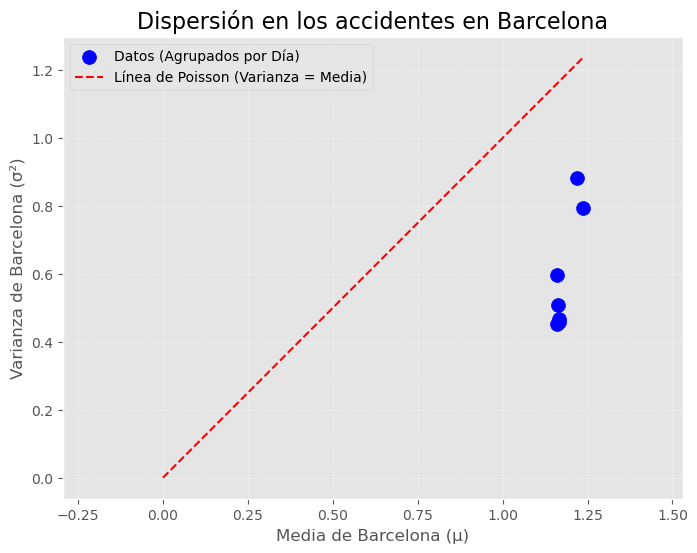

In [27]:
calc_dispersion(acc, column="Numero_victimes", title="Dispersión en los accidentes en Barcelona")

De nuevo, observamos que los datos se alejan bastante (aunque algo menos) de la línea de Poisson. Así que vayamos al análisis de la regresión, a ver qué nos dice.


--- Comprobación Numérica (Media vs. Varianza) ---
           min      mean   max       var
Weekday                                 
Lunes      0.0  1.163009  12.0  0.509258
Martes     0.0  1.165040  14.0  0.457944
Miércoles  0.0  1.165876  13.0  0.468621
Jueves     0.0  1.160916  26.0  0.597977
Viernes    0.0  1.161150  11.0  0.451185
Sábado     0.0  1.236400  12.0  0.794254
Domingo    0.0  1.218699  15.0  0.881618


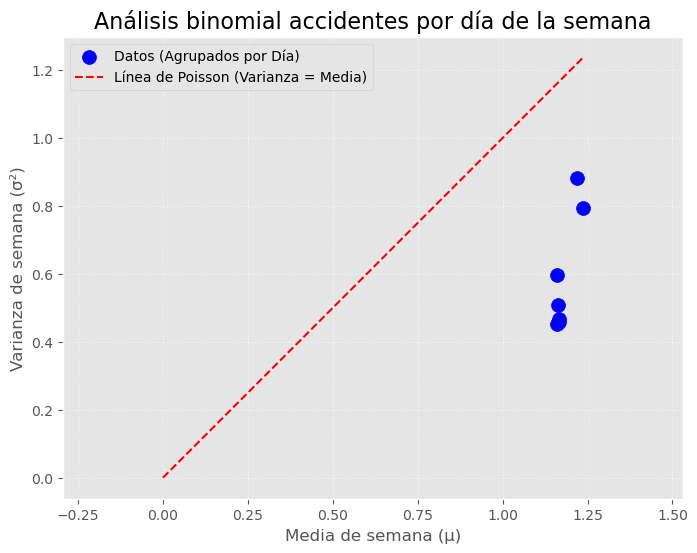

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Generalized linear model
=====================================================================================
Model:                      GLM                    AIC:                  169168.2092 
Link Function:              Log                    BIC:                  -604259.4841
Dependent Variable:         Numero_victimes        Log-Likelihood:       -84570.     
Date:                       2025-10-27 23:03       LL-Null:              -84578.     
No. Observations:           56333                  Deviance:             11816.      
Df Model:                   13                     Pearson chi2:         1.23e+04    
Df Residuals:               56319                  Scale:                1.0000      
Method:                     IRLS                                                     
-------------------------------------------------------------------------------------
                                        Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                               0.1404   0.0207  6.7825 0.0000  0.0998 0.1810
C(Q("Fase Lunar"))[T.Luna Creciente]    0.0123   0.0227  0.5421 0.5878 -0.0322 0.0568
C(Q("Fase Lunar"))[T.Cuarto Creciente]  0.0118   0.0221  0.5323 0.5945 -0.0316 0.0551
C(Q("Fase Lunar"))[T.Gibosa Creciente]  0.0114   0.0227  0.4996 0.6173 -0.0332 0.0559
C(Q("Fase Lunar"))[T.Luna Llena]        0.0133   0.0228  0.5852 0.5584 -0.0313 0.0580
C(Q("Fase Lunar"))[T.Gibosa Menguante]  0.0082   0.0221  0.3713 0.7104 -0.0351 0.0515
C(Q("Fase Lunar"))[T.Cuarto Menguante]  0.0108   0.0228  0.4727 0.6364 -0.0339 0.0555
C(Q("Fase Lunar"))[T.Luna Menguante]    0.0186   0.0227  0.8195 0.4125 -0.0259 0.0632
C(Weekday)[T.Martes]                    0.0017   0.0208  0.0821 0.9345 -0.0390 0.0424
C(Weekday)[T.Miércoles]                 0.0024   0.0206  0.1177 0.9063 -0.0380 0.0429
C(Weekday)[T.Jueves]                   -0.0017   0.0206 -0.0841 0.9329 -0.0420 0.0386
C(Weekday)[T.Viernes]                  -0.0015   0.0204 -0.0753 0.9400 -0.0416 0.0385
C(Weekday)[T.Sábado]                    0.0613   0.0224  2.7359 0.0062  0.0174 0.1052
C(Weekday)[T.Domingo]                   0.0467   0.0243  1.9228 0.0545 -0.0009 0.0944
=====================================================================================

"""

In [28]:
accidentes = binomial_anaysis(accidents, "Numero_victimes", "Análisis binomial accidentes por día de la semana")
accidentes.summary2()

Y vemos que el domingo sí muestra relación... y el sábado está por debajo del 0.01, es decir, por debajo del 1%, concretamente, en un 0,62%. Es mucha relación. La única que hemos visto tan clara en todos los análisis efectuados. Pero aún nos queda la relación con las fases lunares. Primero, la dispersión:


--- Comprobación Numérica (Media vs. Varianza) ---
                  min      mean   max       var
Fase Lunar                                     
Luna Nueva        0.0  1.164471  13.0  0.527211
Luna Creciente    0.0  1.178191  12.0  0.533043
Cuarto Creciente  0.0  1.177299  14.0  0.575499
Gibosa Creciente  0.0  1.176297  11.0  0.517688
Luna Llena        0.0  1.181450  15.0  0.623597
Gibosa Menguante  0.0  1.173105  26.0  0.574385
Cuarto Menguante  0.0  1.176506  11.0  0.509527
Luna Menguante    0.0  1.185697  26.0  0.664247


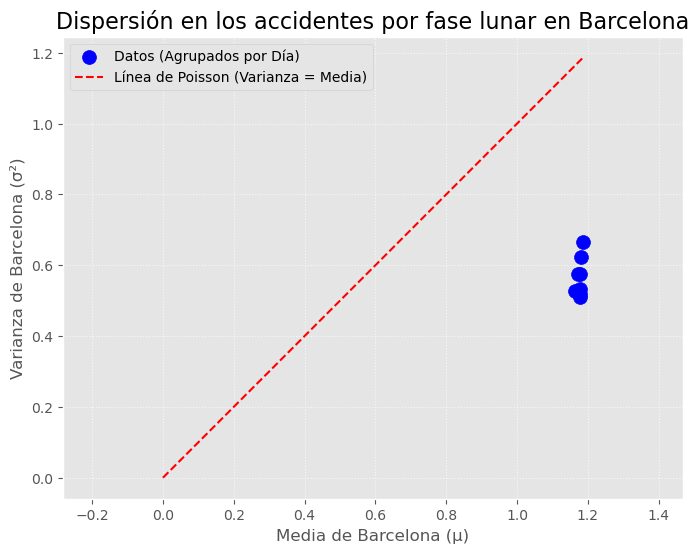

In [29]:
calc_dispersion_lph(acc, column="Numero_victimes", title="Dispersión en los accidentes por fase lunar en Barcelona")

In [30]:
rweekdays = weekdays[1:].copy()
rphases   = list(moon_phases_txt.values())[1:]

In [31]:
# rweekdays.reverse()
# rphases.reverse()
print(rweekdays, "\n", rphases)  

['Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'] 
 ['Luna Creciente', 'Cuarto Creciente', 'Gibosa Creciente', 'Luna Llena', 'Gibosa Menguante', 'Cuarto Menguante', 'Luna Menguante']


In [33]:
accidentes.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Generalized linear model
=====================================================================================
Model:                      GLM                    AIC:                  169168.2092 
Link Function:              Log                    BIC:                  -604259.4841
Dependent Variable:         Numero_victimes        Log-Likelihood:       -84570.     
Date:                       2025-10-27 23:04       LL-Null:              -84578.     
No. Observations:           56333                  Deviance:             11816.      
Df Model:                   13                     Pearson chi2:         1.23e+04    
Df Residuals:               56319                  Scale:                1.0000      
Method:                     IRLS                                                     
-------------------------------------------------------------------------------------
                                        Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                               0.1404   0.0207  6.7825 0.0000  0.0998 0.1810
C(Q("Fase Lunar"))[T.Luna Creciente]    0.0123   0.0227  0.5421 0.5878 -0.0322 0.0568
C(Q("Fase Lunar"))[T.Cuarto Creciente]  0.0118   0.0221  0.5323 0.5945 -0.0316 0.0551
C(Q("Fase Lunar"))[T.Gibosa Creciente]  0.0114   0.0227  0.4996 0.6173 -0.0332 0.0559
C(Q("Fase Lunar"))[T.Luna Llena]        0.0133   0.0228  0.5852 0.5584 -0.0313 0.0580
C(Q("Fase Lunar"))[T.Gibosa Menguante]  0.0082   0.0221  0.3713 0.7104 -0.0351 0.0515
C(Q("Fase Lunar"))[T.Cuarto Menguante]  0.0108   0.0228  0.4727 0.6364 -0.0339 0.0555
C(Q("Fase Lunar"))[T.Luna Menguante]    0.0186   0.0227  0.8195 0.4125 -0.0259 0.0632
C(Weekday)[T.Martes]                    0.0017   0.0208  0.0821 0.9345 -0.0390 0.0424
C(Weekday)[T.Miércoles]                 0.0024   0.0206  0.1177 0.9063 -0.0380 0.0429
C(Weekday)[T.Jueves]                   -0.0017   0.0206 -0.0841 0.9329 -0.0420 0.0386
C(Weekday)[T.Viernes]                  -0.0015   0.0204 -0.0753 0.9400 -0.0416 0.0385
C(Weekday)[T.Sábado]                    0.0613   0.0224  2.7359 0.0062  0.0174 0.1052
C(Weekday)[T.Domingo]                   0.0467   0.0243  1.9228 0.0545 -0.0009 0.0944
=====================================================================================

"""

['Luna Nueva', 'Luna Creciente', 'Cuarto Creciente', 'Gibosa Creciente', 'Luna Llena', 'Gibosa Menguante', 'Cuarto Menguante', 'Luna Menguante']
C(Q("Fase Lunar"))[T.Luna Creciente]      0.587762
C(Q("Fase Lunar"))[T.Cuarto Creciente]    0.594511
C(Q("Fase Lunar"))[T.Gibosa Creciente]    0.617332
C(Q("Fase Lunar"))[T.Luna Llena]          0.558443
C(Q("Fase Lunar"))[T.Gibosa Menguante]    0.710409
C(Q("Fase Lunar"))[T.Cuarto Menguante]    0.636420
C(Q("Fase Lunar"))[T.Luna Menguante]      0.412487
C(Weekday)[T.Martes]                      0.934532
C(Weekday)[T.Miércoles]                   0.906284
C(Weekday)[T.Jueves]                      0.932940
C(Weekday)[T.Viernes]                     0.939969
C(Weekday)[T.Sábado]                      0.006221
C(Weekday)[T.Domingo]                     0.054509
dtype: float64


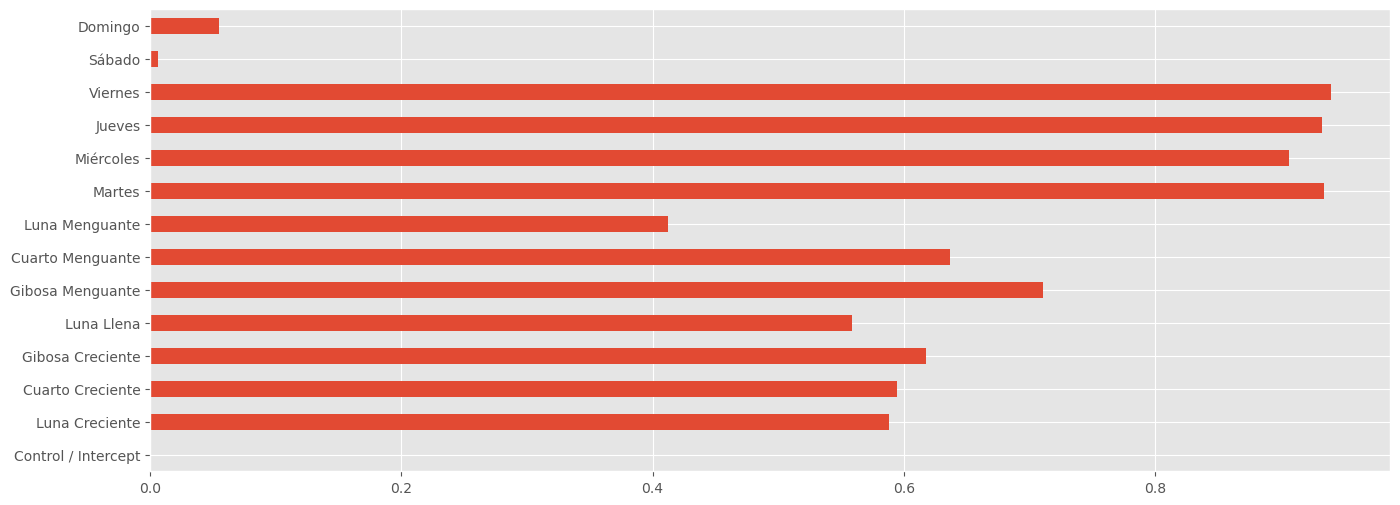

In [32]:
from color_helpers import column_colors

ticks = ["Control / Intercept"] + rphases + rweekdays

print(list(moon_phases_txt.values()))
# faltarían los colores, aquí
print(accidentes.pvalues[1:])
gracc = accidentes.pvalues.plot.barh(figsize=(16,6))
gracc.set_yticks(range(0, ticks.__len__()), ticks)
